In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

import cv2
import numpy as np

from src.models.modnet import MODNet
from PIL import Image
import PIL

In [28]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [47]:
img_ori = cv2.imread('/home/ubuntu/data/yong/projects/MODNet/demo.jpeg', cv2.IMREAD_COLOR)
im_h, im_w, im_c = img_ori.shape

img_ori = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)

img_np = cv2.resize(img_ori, (512, 512), interpolation=cv2.INTER_LINEAR)

In [48]:
im_tensor = torch.from_numpy(img_np.astype(np.float32)).permute(2, 0, 1)

im_tensor = im_tensor / 255.0
im_tensor = normalize(im_tensor)

In [49]:
modnet = MODNet(backbone_pretrained=False)
modnet = nn.DataParallel(modnet)

In [50]:
modnet = modnet.cuda()
modnet.load_state_dict(torch.load('/home/ubuntu/data/yong/projects/MODNet/output/matting_0001.ckpt'))

<All keys matched successfully>

In [51]:
modnet.eval()

DataParallel(
  (module): MODNet(
    (backbone): MobileNetV2Backbone(
      (model): MobileNetV2(
        (features): Sequential(
          (0): Sequential(
            (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): InvertedResidual(
            (conv): Sequential(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
              (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
          )
          (2): InvertedResidual(
            (conv): Sequential(
              (0): C

In [52]:
im_tensor = im_tensor[None, :, :, :]

In [53]:
_, _, matte_tensor = modnet(im_tensor.cuda(), True)

In [54]:
matte_tensor = F.interpolate(matte_tensor, size=(im_h, im_w), mode='area')
matte_tensor = matte_tensor.repeat(1, 3, 1, 1)
matte_np = matte_tensor[0].data.cpu().numpy().transpose(1, 2, 0)
fg_np = matte_np * img_ori + (1 - matte_np) * np.full(img_ori.shape, 255.0)
fg_PIL = PIL.Image.fromarray(np.uint8(fg_np))

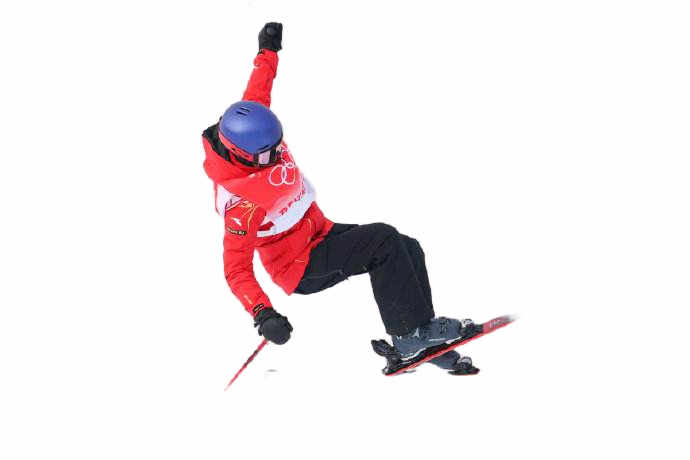

In [55]:
fg_PIL